# Consensus Whole Mouse Brain #2: 10X gene expression

In the [previous notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html), we explored the integrated taxonomy and combined it with cell level and other metadata. In this notebook, we load and explore gene expression data, loading the expression of specific genes. We plot these expressions in the heatmaps, comparing the expression across the taxonomy and anatomical region, as well as show the gene expression in the UMAP.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
download_base = Path('../../data/allen-brain-cell-atlas-staging')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
    s3_bucket='allen-brain-cell-atlas-staging',
    auth_required=True,
)

abc_cache.current_manifest

'releases/20251031/manifest.json'

Below we create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html).

In [ ]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    'Consensus-WMB-integrated-taxonomy', 'cell_to_cluster_membership'
).set_index('cell_label')
cluster = abc_cache.get_metadata_dataframe(
    'Consensus-WMB-integrated-taxonomy', 'cluster'
).set_index('label')
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    'Consensus-WMB-integrated-taxonomy', 'cluster_annotation_term'
).set_index('label')

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-integrated-taxonomy',
    file_name='cluster_annotation_term_set'
).set_index('label')

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-integrated-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
).set_index('cluster_annotation_term_label')

macosko_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-WMB-Macosko-10X', 'cell_metadata').set_index('cell_label')
aibs_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-WMB-AIBS-10X', 'cell_metadata').set_index('cell_label')

membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)

membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()

membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['neighborhood', 'class', 'subclass', 'supertype', 'cluster'], inplace=True)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['neighborhood', 'class', 'subclass', 'supertype', 'cluster'],
    inplace=True
)

aibs_cell_extended = aibs_cell_metadata.join(cell_to_cluster_membership, how='inner')
aibs_cell_extended = aibs_cell_extended.join(cluster_details, on='cluster_alias')
aibs_cell_extended = aibs_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
aibs_cell_extended = aibs_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

aibs_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-AIBS-10X',
    file_name='library'
).set_index('library_label')
aibs_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-AIBS-10X',
    file_name='donor'
).set_index('donor_label')
aibs_cell_extended = aibs_cell_extended.join(aibs_library, on='library_label')
aibs_cell_extended = aibs_cell_extended.join(aibs_donor, on='donor_label')

macosko_cell_extended = macosko_cell_metadata.join(cell_to_cluster_membership, how='inner')
macosko_cell_extended = macosko_cell_extended.join(cluster_details, on='cluster_alias')
macosko_cell_extended = macosko_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
macosko_cell_extended = macosko_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

macosko_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-Macosko-10X',
    file_name='library'
).set_index('library_label')
macosko_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-Macosko-10X',
    file_name='donor'
).set_index('donor_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_library, on='library_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_donor, on='donor_label')

### Single cell and nuclei transcriptomes

Below we use the convenience function `get_gene_data` to download and extract specific genes from the gene expression h5ad files. This function can be used to pull expression for the full set of cells or any subset from the set of cell metadata.

We first load the gene data for the WMB portion of the consensus dataset.

In [ ]:
aibs_gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(aibs_gene))
aibs_gene.head(5)

gene.csv: 100%|██████████| 2.30M/2.30M [00:00<00:00, 2.88MMB/s]


Number of aligned genes =  32285


gene_symbol                               name  \
gene_identifier                                                     
ENSMUSG00000051951        Xkr4  X-linked Kx blood group related 4   
ENSMUSG00000089699      Gm1992                predicted gene 1992   
ENSMUSG00000102331     Gm19938              predicted gene, 19938   
ENSMUSG00000102343     Gm37381              predicted gene, 37381   
ENSMUSG00000025900         Rp1     retinitis pigmentosa 1 (human)   

                   mapped_ncbi_identifier comment  
gene_identifier                                    
ENSMUSG00000051951        NCBIGene:497097     NaN  
ENSMUSG00000089699                    NaN     NaN  
ENSMUSG00000102331                    NaN     NaN  
ENSMUSG00000102343                    NaN     NaN  
ENSMUSG00000025900         NCBIGene:19888     NaN

Next we load the same metadata for the Macosko data. Note that the two samples have slightly different sets of genes, however, they have a large overlap. 

In [5]:
macosko_gene = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-Macosko-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(macosko_gene))
macosko_gene.head(5)

gene.csv: 100%|██████████| 546k/546k [00:00<00:00, 1.99MMB/s] 

Number of aligned genes =  21205


gene_symbol
gene_identifier               
ENSMUSG00000072572     Slc39a2
ENSMUSG00000063179        Pstk
ENSMUSG00000041220      Elovl6
ENSMUSG00000042246        Tmc7
ENSMUSG00000075072      Olfr48

Below we list the genes we will use in this notebook and the example method used to load the expression for these specific genes from the h5ad file. Note that we provide a set of example gene expressions as a csv file for brevity in this tutorial. To process and extract the gene expressions for yourself, uncomment the code block below. Note that there are two different calls one for the WMB-AIBS data and one for the WMB-Macosko data. These two calls need to be separated but the results can be combined afterward.

For more details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [27]:
gene_names = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc18a3', 'Slc6a3', 'Slc6a4', 'Slc6a2']
"""
aibs_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=aibs_cell_metadata,
    all_genes=aibs_gene,
    selected_genes=gene_names
)
"""

'\naibs_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=aibs_cell_metadata,\n    all_genes=aibs_gene,\n    selected_genes=gene_names\n)\n'

In [7]:
"""
macosko_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=macosko_cell_metadata,
    all_genes=macosko_gene,
    selected_genes=gene_names
)
"""

'\nmacosko_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=macosko_cell_metadata,\n    all_genes=macosko_gene,\n    selected_genes=gene_names\n)\n'

Instead of processing the gene expressions, we load a pre-processed file.

In [ ]:
macosko_gene_data = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-Macosko-10X',
    file_name='example_gene_expression'
).set_index('cell_label')
aibs_gene_data = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-AIBS-10X',
    file_name='example_gene_expression'
).set_index('cell_label')

example_gene_expression.csv: 100%|██████████| 330M/330M [01:09<00:00, 4.73MMB/s]    
example_gene_expression.csv: 100%|██████████| 291M/291M [00:49<00:00, 5.84MMB/s]    


We load and merge the expression into each of our cell metadata.

In [ ]:
aibs_cell_extended = aibs_cell_extended.join(aibs_gene_data)
macosko_cell_extended = macosko_cell_extended.join(macosko_gene_data)

## Example use cases

In this section, we show a use case plotting a set of genes that map onto a cononical set of neurotransmitters. These are the same set of genes used in the [WMB-AIBS tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_2b.html).

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [10]:
import matplotlib as mpl

def plot_heatmap(
    df: pd.DataFrame,
    gnames: List[str],
    value: str,
    sort: bool = False,
    fig_width: float = 8,
    fig_height: float = 4,
    vmax: float = None,
    cmap: plt.cm = plt.cm.magma
):
    """Plot a heatmap of gene expression values for a list of genes across species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata and gene expression values.
    gnames : list
        List of gene names to plot.
    value : str
        Column name in df to group by (e.g., 'species_genus').
    sort : bool, optional
        Whether to sort the gene expression values within each species.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    vmax : float, optional
        Maximum value for the color scale. If None, it is set to the maximum value in the data.
    cmap : matplotlib colormap, optional
        Colormap to use for the heatmap.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the heatmap.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    grouped = df.groupby(value)[gnames].mean()
    vmin = grouped.min().min()
    vmax = grouped.max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
        grouped = grouped.loc[sorted(grouped.index)]

    arr = grouped.to_numpy().astype('float')

    ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = grouped.columns.values
    ylabs = grouped.index.values


    ax.set_yticks(range(len(ylabs)))
    ax.set_yticklabels(ylabs)
    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('Mean Expression [log2(CPM + 1)]')
    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Average expression of selected genes

Below we plot the expression of the genes we selected  averaged across metadata terms in a heatmap. We show these by neighborhood for each experiment/dataset individually and then together. Also, we show selecting a subset of cells by their neighborhood value and both plotting them in the heatmap and an example function loading gene expression for this subset of cells only. 

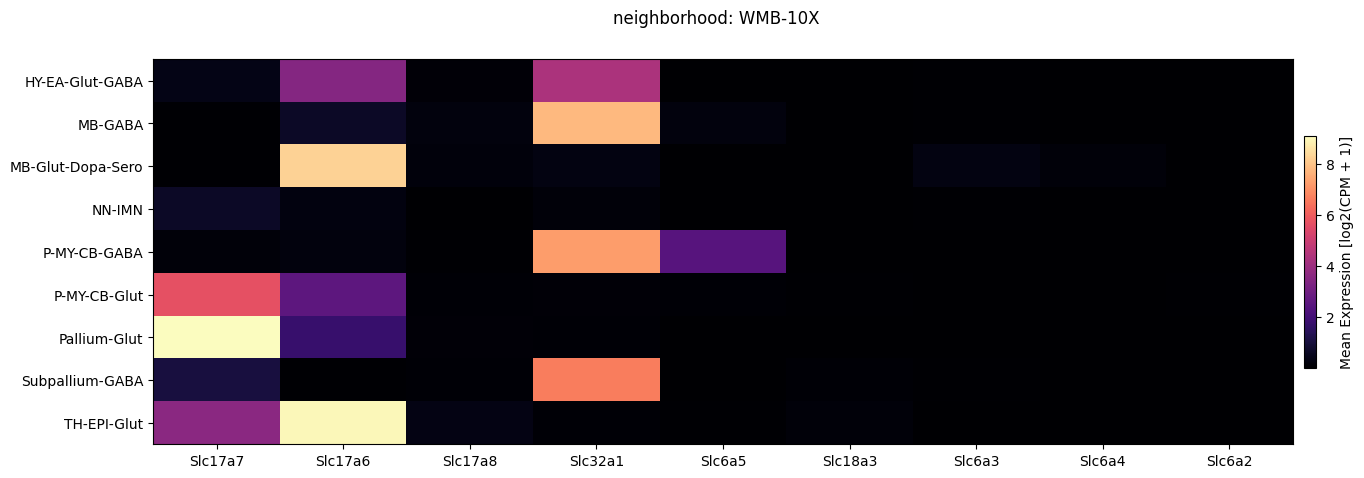

In [ ]:
fig, ax = plot_heatmap(
    df=aibs_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: WMB-AIBS')
plt.show()

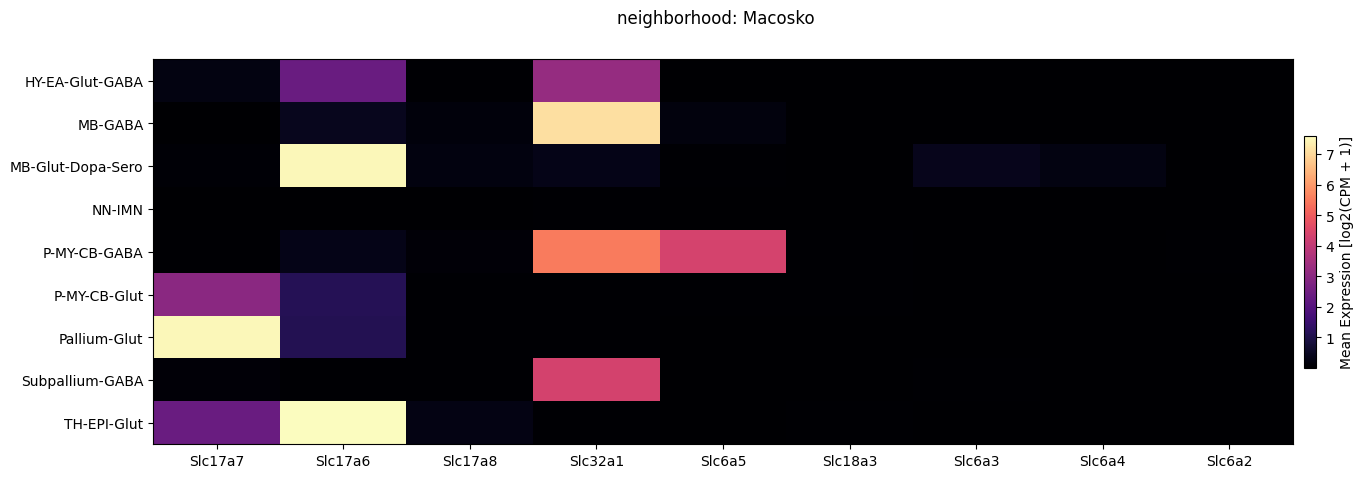

In [ ]:
fig, ax = plot_heatmap(
    df=macosko_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: WMB-Macosko')
plt.show()

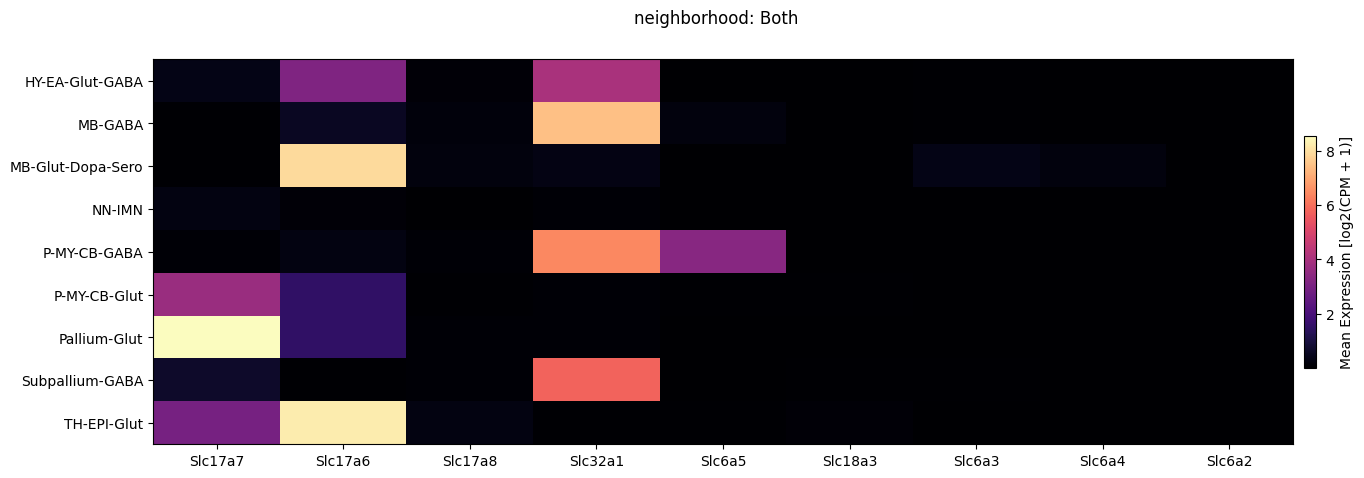

In [ ]:
full_cell_extended = pd.concat([aibs_cell_extended, macosko_cell_extended])
fig, ax = plot_heatmap(
    df=full_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: Both')
plt.show()

Next we show the selected genes by neurotransmitter for both datasets.

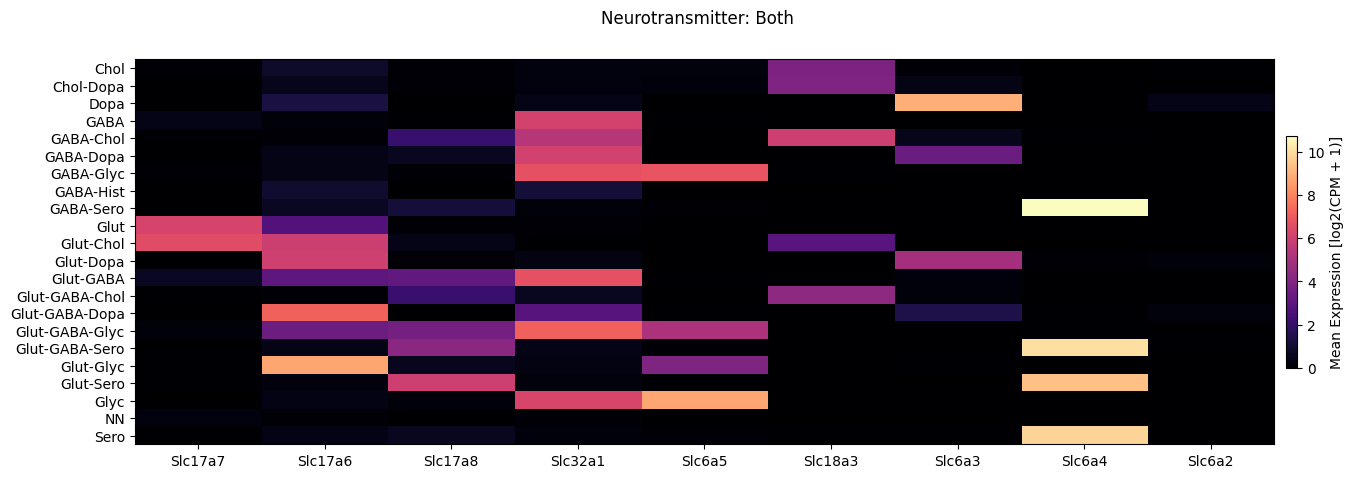

In [14]:
fig, ax = plot_heatmap(
    df=full_cell_extended,
    gnames=gene_names,
    value='neurotransmitter',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Neurotransmitter: Both')
plt.show()

Finally, we break down the expression by anatomical region symbol.

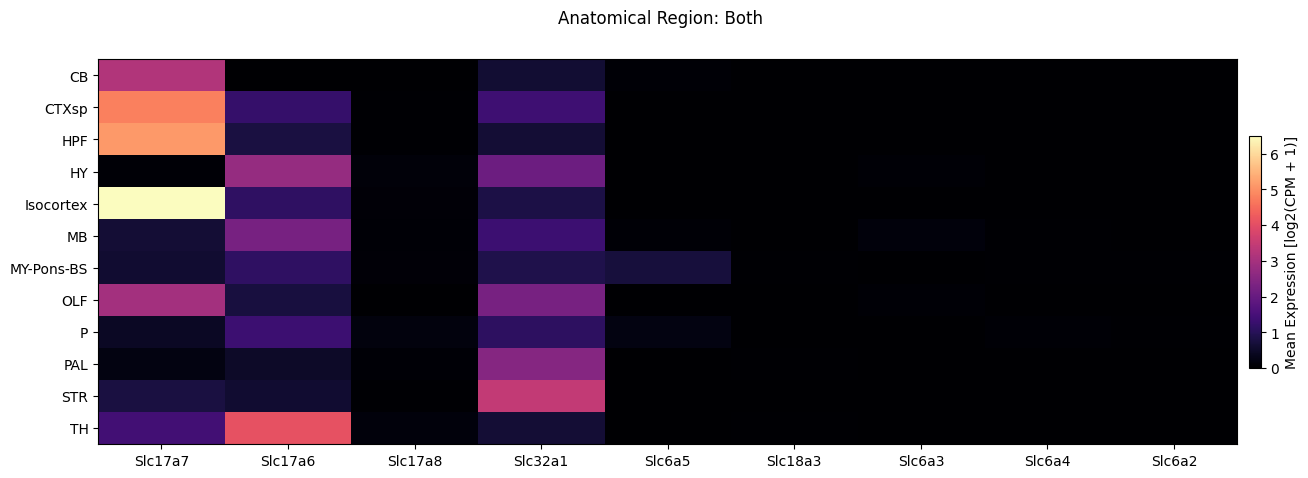

In [15]:
fig, ax = plot_heatmap(
    df=full_cell_extended,
    gnames=gene_names,
    value='anatomical_division_label',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Anatomical Region: Both')
plt.show()

#### Individual neighborhood gene expression

Next, we'll plot the same expression vs anatomical_region, but now we'll do so for only one of the neighborhoods, Pallium-Glut. Note that we expect the plot to be fairly dark as we are only showing the Pallium-Glut data and not all the canonical neurotransmitters will show expression.

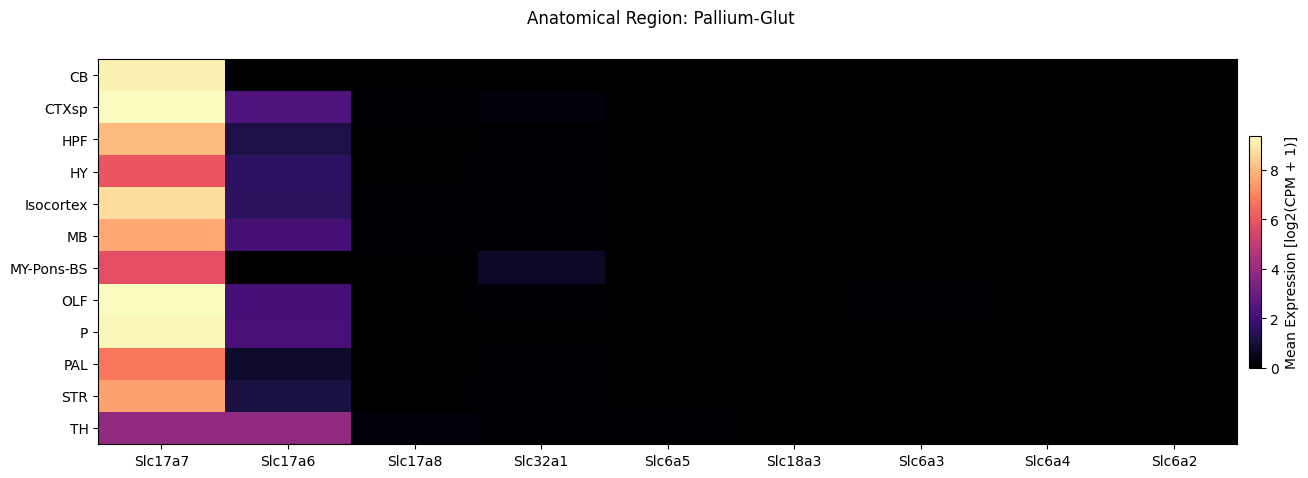

In [17]:
fig, ax = plot_heatmap(
    df=full_cell_extended[full_cell_extended['neighborhood'] == 'Pallium-Glut'],
    gnames=gene_names,
    value='anatomical_division_label',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Anatomical Region: Pallium-Glut')
plt.show()

We can also directly use the trimmed down cell metadata table in the `get_gene_data` function to retrieve a expression for a subset of cells only.

In [ ]:
# Uncomment below to for an example of how to extract gene expression for a subset of cells only
example_gene_selection = ['Elovl6']
"""
aibs_sub_cells_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=aibs_cell_extended[aibs_cell_extended['neighborhood'] == 'Pallium-Glut'],
    all_genes=aibs_gene,
    selected_genes=example_gene_selection
)"""

"""
macosko_sub_cells_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=macosko_cell_extended[macosko_cell_extended['neighborhood'] == 'Pallium-Glut'],
    all_genes=macosko_gene,
    selected_genes=example_gene_selection
)
"""

"\nmacosko_sub_cells_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=macosko_cell_extended[macosko_cell_extended['neighborhood'] == 'Pallium-Glut'],\n    all_genes=macosko_gene,\n    selected_genes=example_gene_selection\n)\n"

## Expression in the UMAP

Finally, we load the UMAP coordinates for our cells and plot the expression in the UMAP for each of our selected genes.

We could also load one of the neighborhood UMAPs that we showed in the [previous notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html).

In [18]:
cell_2d_embedding_coordinates = value_sets = abc_cache.get_metadata_dataframe(
    directory='Consensus-WMB-integrated-taxonomy',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x         y
cell_label                                   
GCGAGAAGTTAAGGGC-410_B05  16.037980  3.101109
AATGGCTCAGCTCCTT-411_B06  15.951514  3.144049
AACACACGTTGCTTGA-410_B05  15.900673  3.124507
CACAGATAGAGGCGGA-410_A05  16.062553  3.185574
GATCGTATCGAATCCA-411_B06  15.971468  3.124298

Join the coordinates into the cell metadata.

In [19]:
consensus_extended = full_cell_extended.join(
    cell_2d_embedding_coordinates
).sample(frac=1)
consensus_extended.head()

cell_barcode  \
cell_label                                                        
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA  GCTGAATCAGCTCATA   
GTGCTTCCAATAGGGC-116_D01                       GTGCTTCCAATAGGGC   
CGCGGTAAGCGGATCA-036_D01                       CGCGGTAAGCGGATCA   
CCTAAGACATTATGCG-149_B01                       CCTAAGACATTATGCG   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC    TTCAGGATCAGAGTTC   

                                              barcoded_cell_sample_label  \
cell_label                                                                 
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA                        NaN   
GTGCTTCCAATAGGGC-116_D01                                         116_D01   
CGCGGTAAGCGGATCA-036_D01                                         036_D01   
CCTAAGACATTATGCG-149_B01                                         149_B01   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC                          NaN   

                                                              library_label  \
cell_label                                                                    
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA  pBICCNsMMrTHT7iM013d210329A1   
GTGCTTCCAATAGGGC-116_D01                                 L8TX_190430_01_D08   
CGCGGTAAGCGGATCA-036_D01                                 L8TX_180815_01_D07   
CCTAAGACATTATGCG-149_B01                                 L8TX_190822_01_H10   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC      pBICCNsMMrBSL6iM010d191022   

                                                           dataset_label  \
cell_label                                                                 
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA  Consensus-WMB-Macosko-10X   
GTGCTTCCAATAGGGC-116_D01                                       WMB-10Xv3   
CGCGGTAAGCGGATCA-036_D01                                       WMB-10Xv2   
CCTAAGACATTATGCG-149_B01                                       WMB-10Xv3   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC    Consensus-WMB-Macosko-10X   

                                                 feature_matrix_label  \
cell_label                                                              
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA          Macosko-10X-TH   
GTGCTTCCAATAGGGC-116_D01                        WMB-10Xv3-Isocortex-2   
CGCGGTAAGCGGATCA-036_D01                                 WMB-10Xv2-TH   
CCTAAGACATTATGCG-149_B01                                 WMB-10Xv3-MB   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC    Macosko-10X-MY-Pons-BS   

                                               cluster_alias           class  \
cell_label                                                                     
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA           5383     012 HY GABA   
GTGCTTCCAATAGGGC-116_D01                               16524  001 IT-ET Glut   
CGCGGTAAGCGGATCA-036_D01                               15193     019 TH Glut   
CCTAAGACATTATGCG-149_B01                               12960   024 P-MB Glut   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC            13118   038 OPC-Oligo   

                                                                          cluster  \
cell_label                                                                          
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA             2035 RT-ZI_Creb5_Gaba 3   
GTGCTTCCAATAGGGC-116_D01                                    0096 L6-IT-CTX_Glut 4   
CGCGGTAAGCGGATCA-036_D01                       3044 TH_Prkcd:Grin2c:Hs3st1_Glut 2   
CCTAAGACATTATGCG-149_B01                            4739 LDT-PCG_Vsx2:Pax5_Glut 2   
pBICCNsMMrBSL6iM010d191022_TTCAGGATCAGAGTTC                     6614 Oligo_NN MOL   

                                                  neighborhood  \
cell_label                                                       
pBICCNsMMrTHT7iM013d210329A1_GCTGAATCAGCTCATA  HY-EA-Glut-GABA   
GTGCTTCCAATAGGGC-116_D01                          Pallium-Glut   
CGCGGTAAGCGGATCA-036_D01    

In [20]:
def plot_umap(
        df: pd.DataFrame,
        feature: str,
        cmap=None,
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        fig_width=12,
        fig_height=12
):
    """Plot UMAP scatter plots for a given feature across multiple species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata including 'x', 'y', and 'species_genus' columns.
    feature : str
        Column name in df to color the points by (e.g., gene expression).
    species_list : list
        List of species to include in the plot.
    cmap : matplotlib colormap, optional
        Colormap to use for coloring the points. If None, uses the feature values as colors directly.
    vmin: float, optional
        Minimum value for color mapping. Defaults to min of values in the feature column. Cells with
        expression below this value will be plotted as light grey.
    vmax: float, optional
        Maximum value for color mapping. Defaults to max of values in the feature column.  Cells with
        expression above this value will be plotted as light grey.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
        

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the UMAP plots.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']

    vv = df[feature]
    if vmin is None:
        vmin = vv.min()

    if vmax is None:
        vmax = vv.max()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    xx = df['x']
    yy = df['y']
    vv = df[feature]

    if cmap is not None:
        mask = np.logical_and(vv >= vmin, vv <= vmax)
        if mask.any():
            ax.scatter(xx[~mask], yy[~mask], s=1.0, c='#D3D3D3', marker='.')
            ax.scatter(xx[mask], yy[mask], s=1.0, c=vv[mask], marker='.', cmap=cmap)
        else:
            ax.scatter(xx, yy, s=1.0, color=vv, marker=".")
    else :
        ax.scatter(xx, yy, s=1.0, color=vv, marker=".")

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('[log2(CPM + 1)]')

    plt.legend(loc=0, markerscale=10)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

/var/folders/kc/7glrmt5n67x16yj_tg86t49c0000gp/T/ipykernel_1464/95516162.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0, markerscale=10)


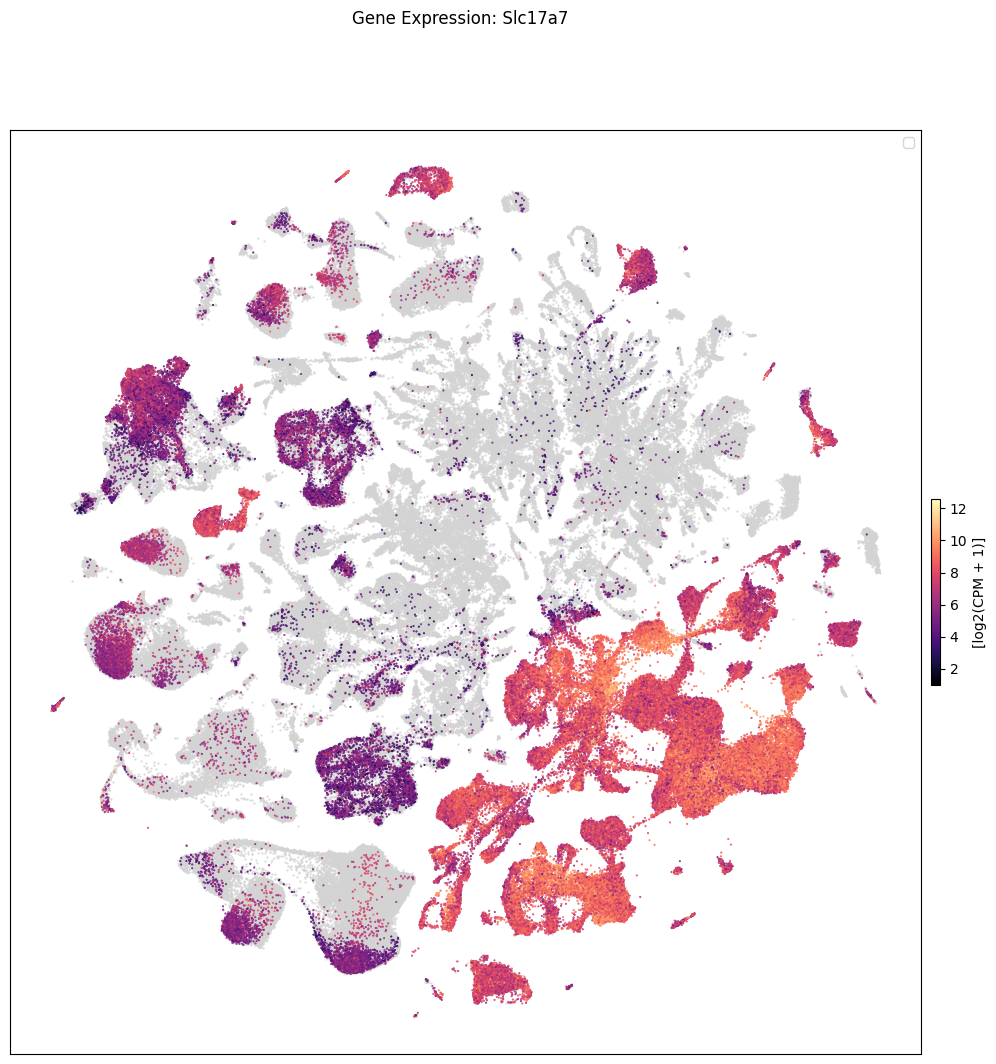

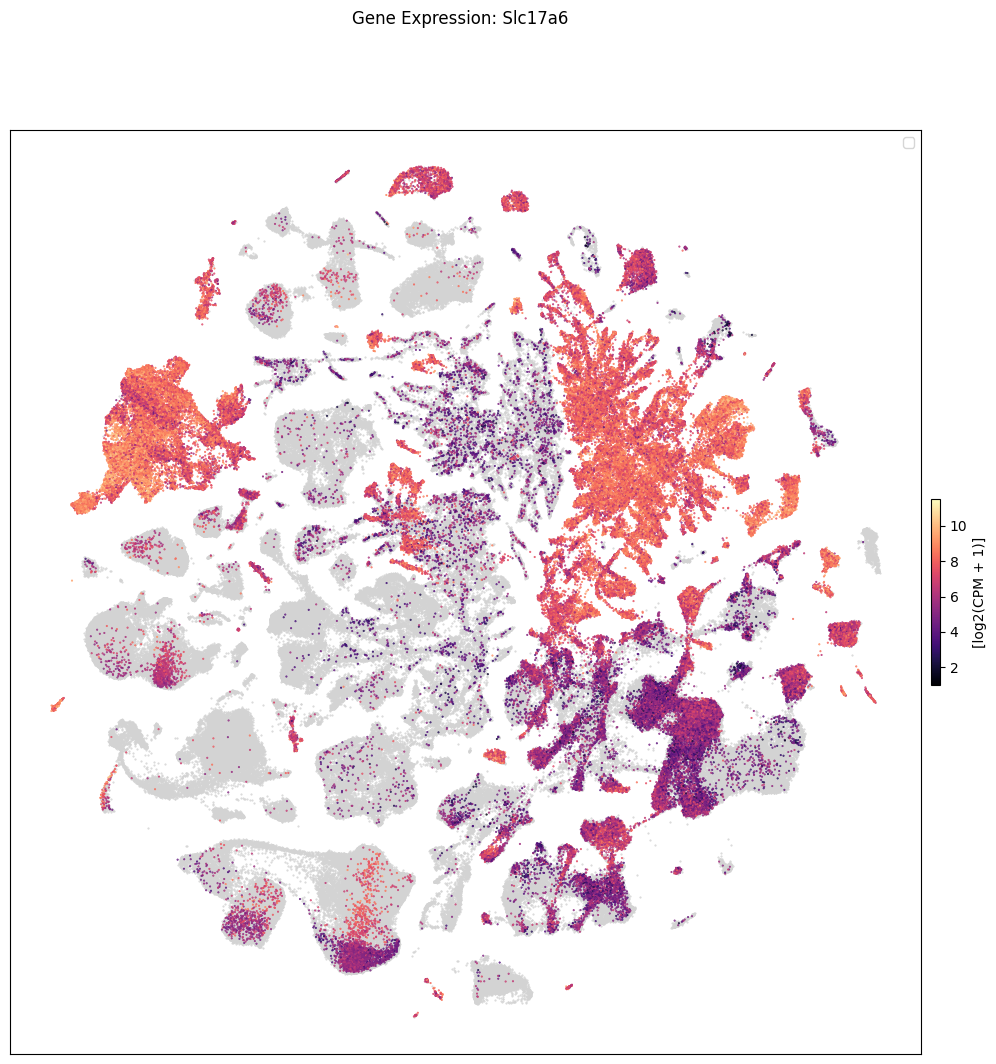

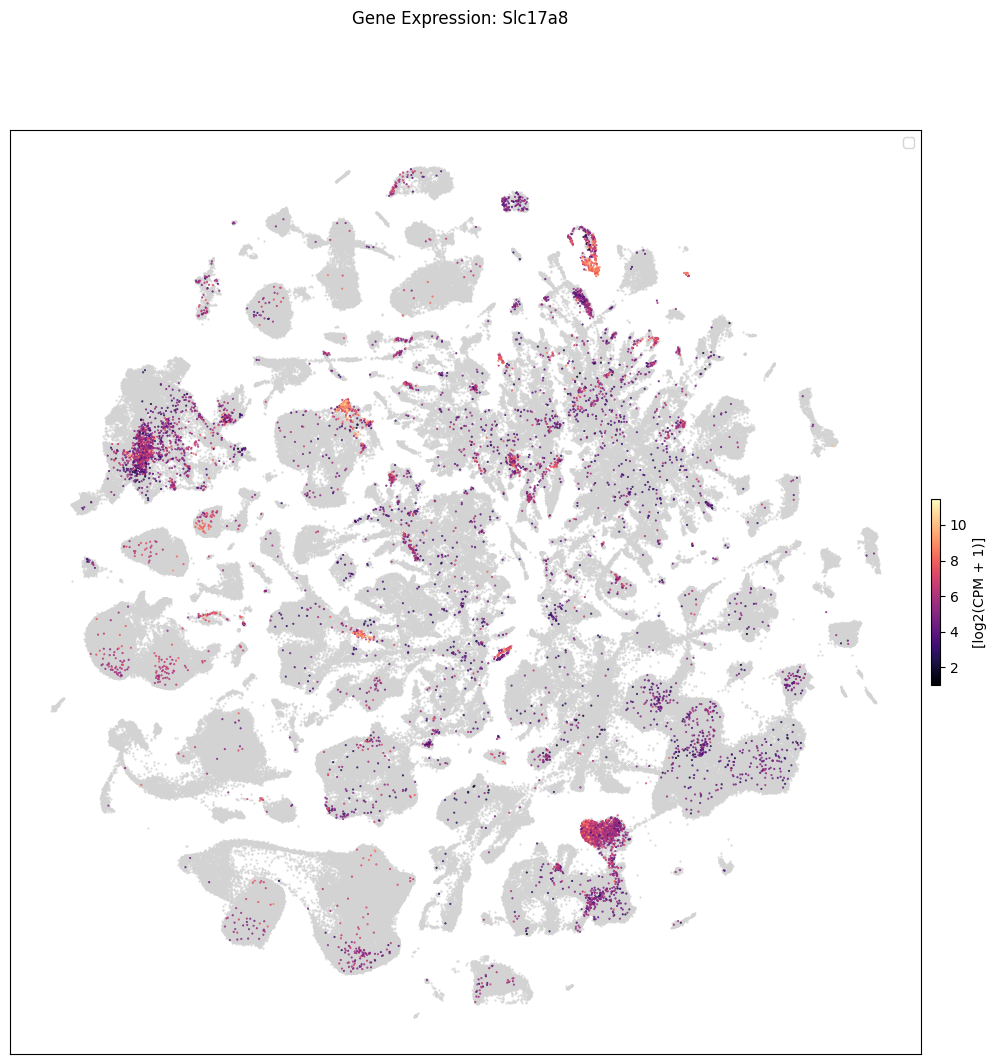

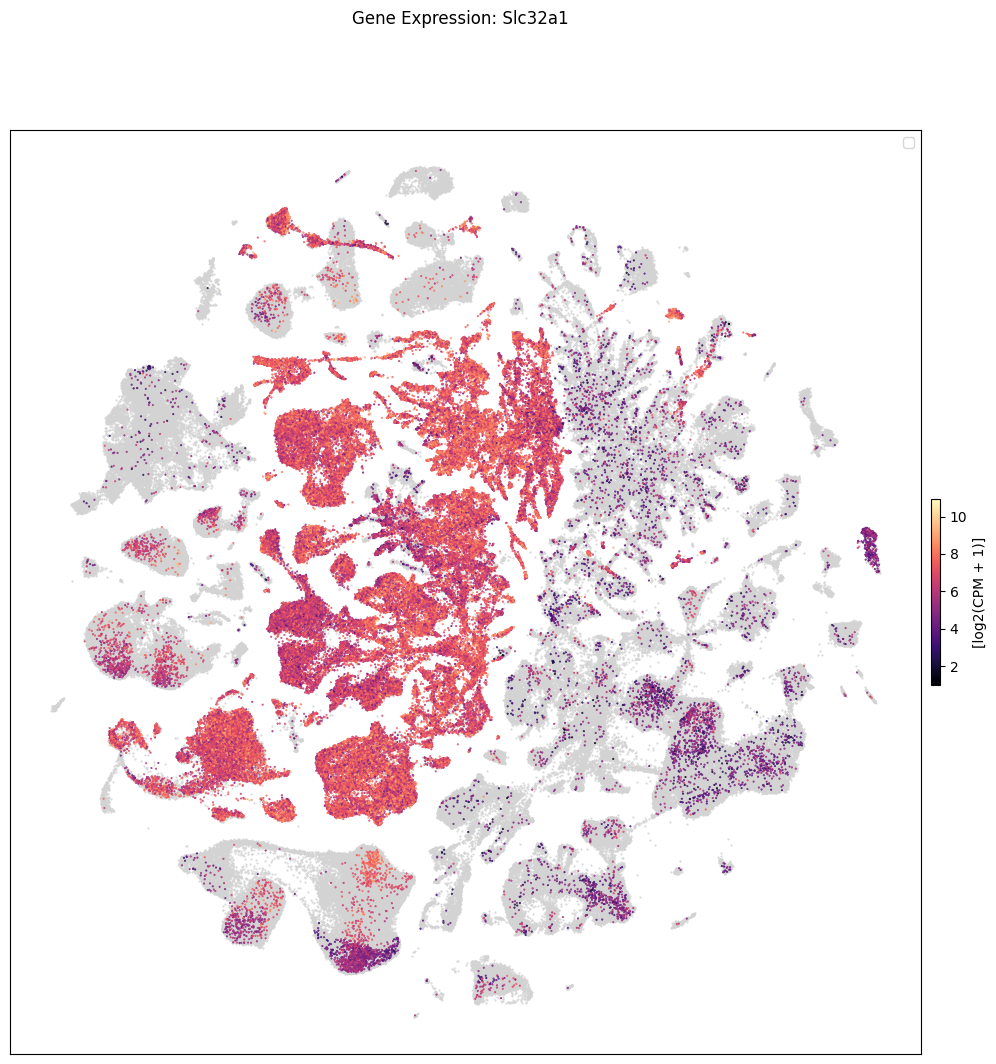

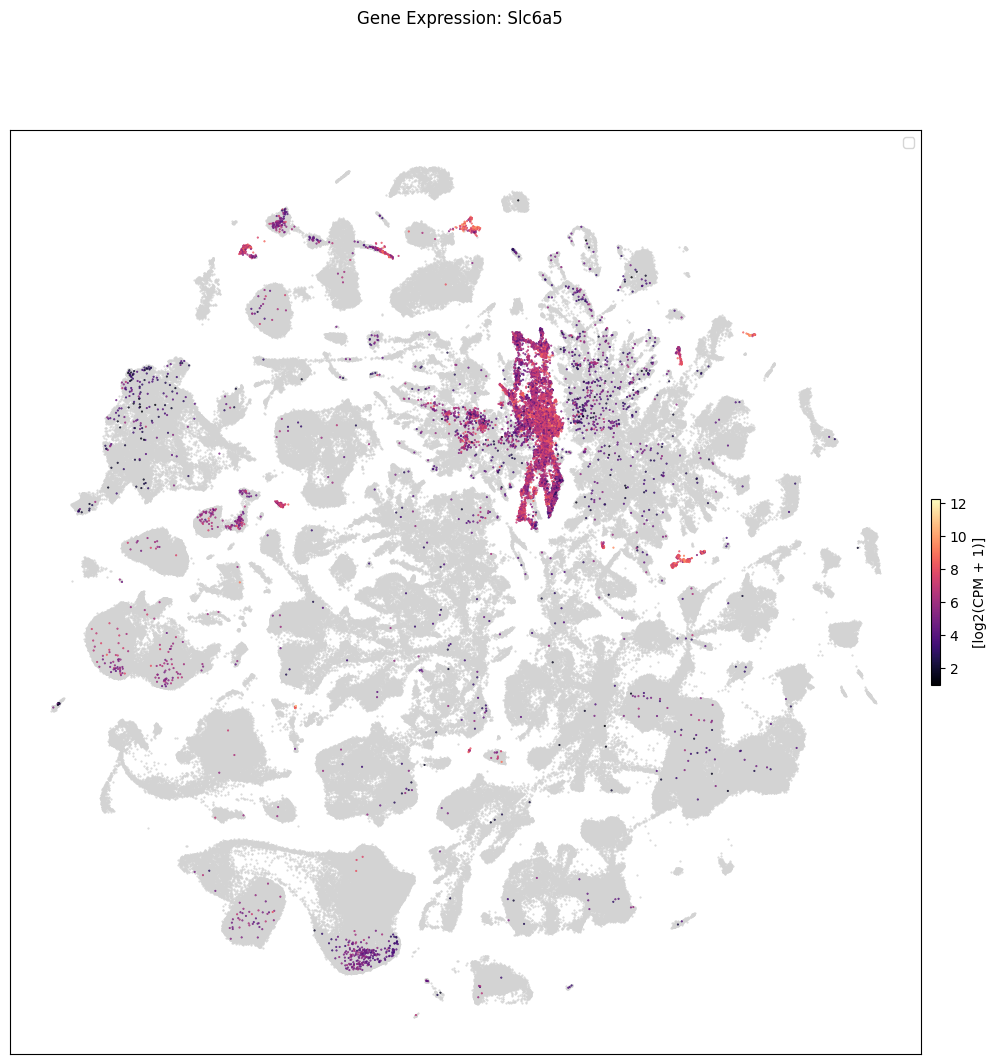

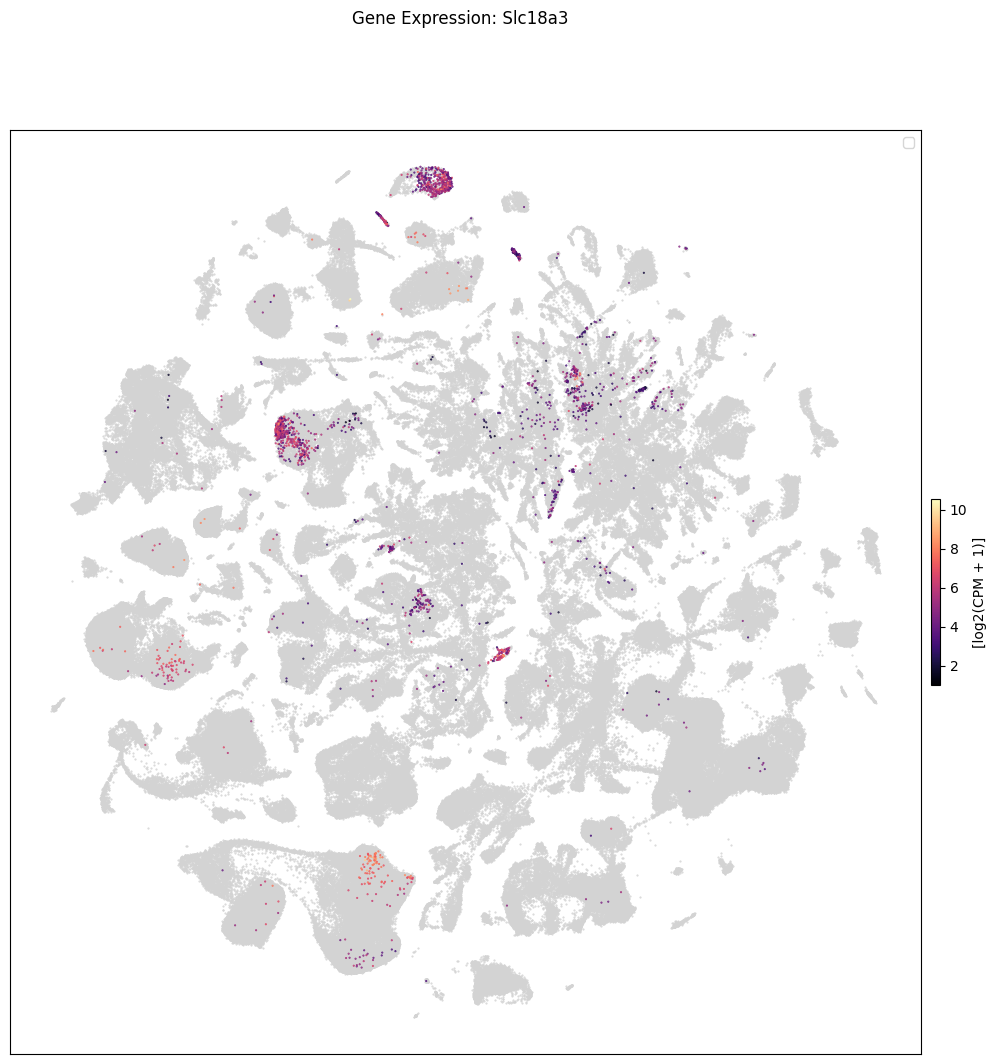

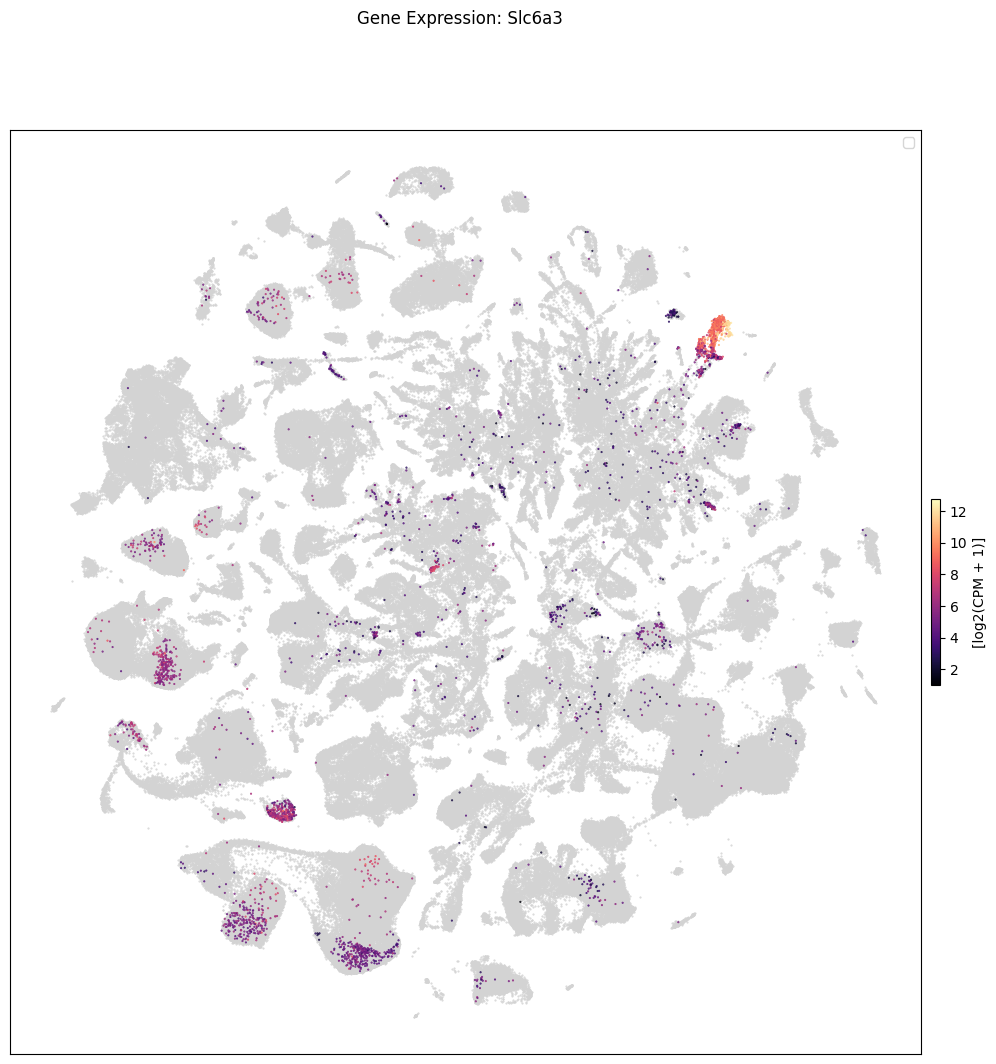

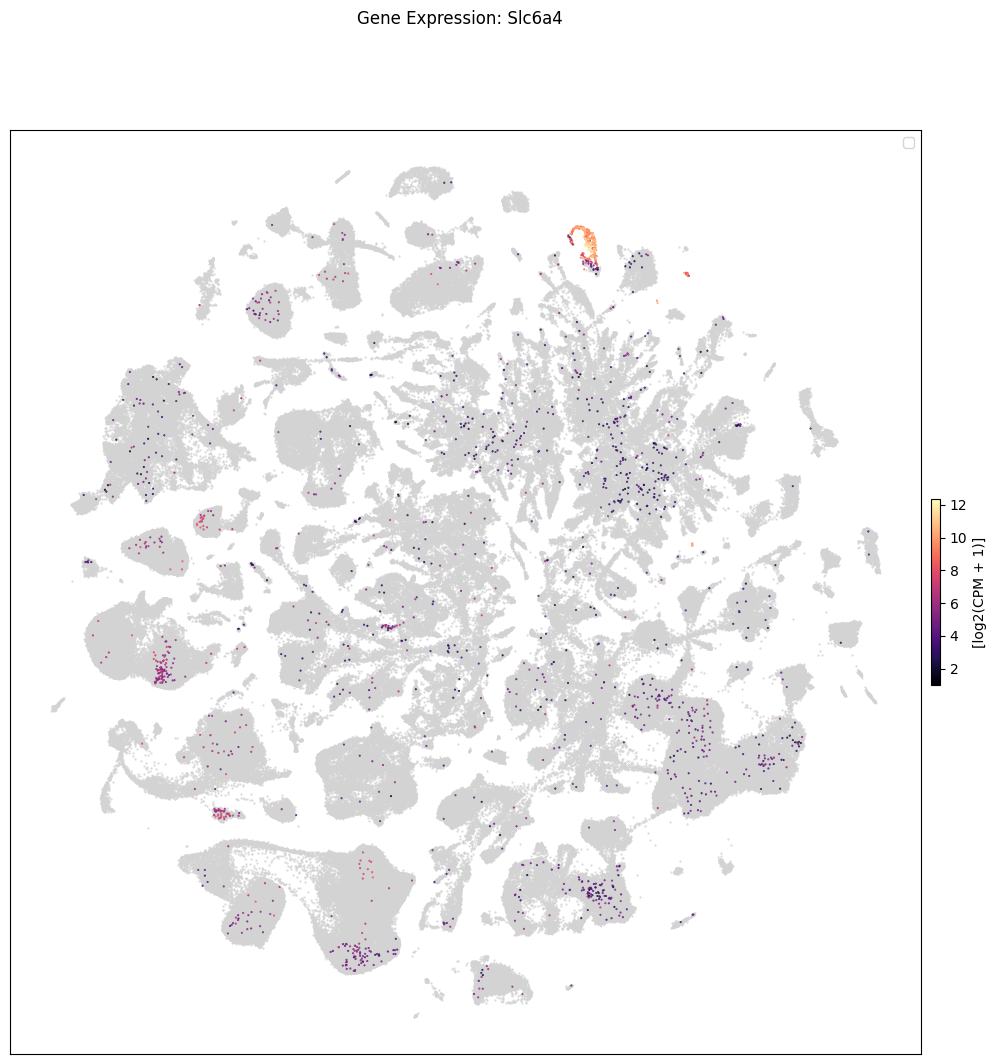

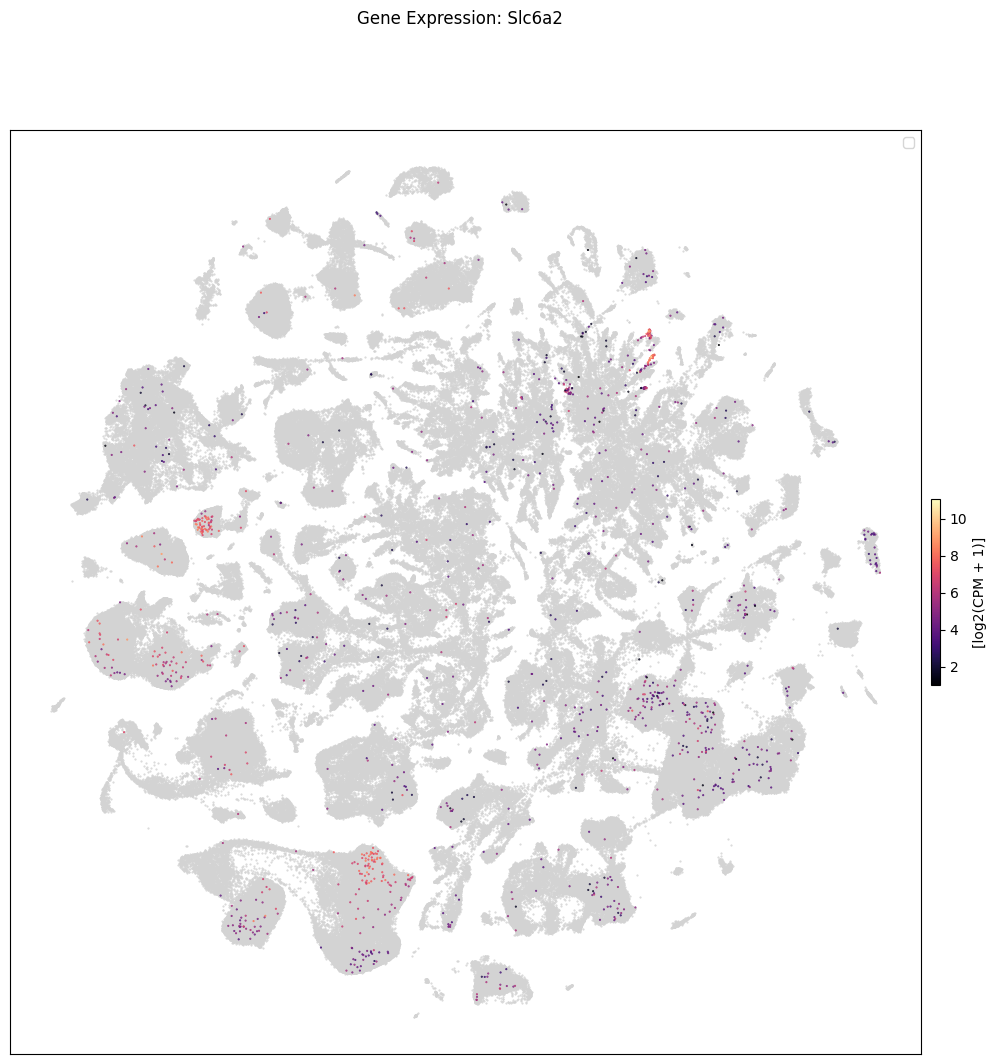

In [21]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        consensus_extended[::10],
        feature=gene_name,
        cmap=plt.cm.magma,
        vmin=1,
        vmax=None,
        
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()

Check out the previous exploration of the taxonomy and clustering annotations [here](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html). The notebooks for the AIBS, Whole Mouse Brain dataset can be found [here](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle1.html).